# Clustering Algorithms on Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
10. TF-IDF weighted W2V<br>
11. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For given Amazon reviews, cluster them into groups using unsupervised algorithms.<br>
<br>
Here I'm using various clustering algorithms(K-means, K-medoid, Hirarchical, DBSCAN) to cluster the reviews into different groups. To convert a review text to numerical features I'm using bag of words(BoW), TF-IDF, Word2Vec and TF-IDF weighted Word2Vec. 

In [1]:
# importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from scipy import stats
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, minmax_scale

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

## 3. Loading the data

In [3]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

In [4]:
data.shape

(364171, 12)

In [5]:
data.head()

index      Id   ProductId          UserId                  ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
3  138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
4  138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   
3                     1                       1  positive  1076025600   
4                     3                       4  positive  1018396800   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   
3      a good swingy rhythm for reading aloud   
4             A great way to learn the months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ...   
3  This is a great little book to read aloud- it ...   
4  This is a book of poetry about the months of t...   

                                         CleanedText  
0  b'witti littl book make son laugh loud recit c...  
1  b'grew read sendak book watch realli rosi movi...  
2  b'fun way children learn month year learn poem...  
3  b'great littl book read nice rhythm well good ...  
4  b'book poetri month year goe month cute littl ...

## 4. Data Preprocessing

In [6]:
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
sorted_data.head(5)

index      Id   ProductId          UserId               ProfileName  \
0    138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
30   138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
424  417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
330  346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
423  417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

     HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
0                       0                       0  positive  939340800   
30                      2                       2  positive  940809600   
424                     0                       0  positive  944092800   
330                     1                       2  positive  944438400   
423                     0                       0  positive  946857600   

                                               Summary  \
0                            EVERY book is educational   
30   This whole series is great way to spend time w...   
424                               Entertainingl Funny!   
330                            A modern day fairy tale   
423                                         FANTASTIC!   

                                                  Text  \
0    this witty little book makes my son laugh at l...   
30   I can remember seeing the show when it aired o...   
424  Beetlejuice is a well written movie ..... ever...   
330  A twist of rumplestiskin captured on film, sta...   
423  Beetlejuice is an excellent and funny movie. K...   

                                           CleanedText  
0    b'witti littl book make son laugh loud recit c...  
30   b'rememb see show air televis year ago child s...  
424  b'beetlejuic well written movi everyth excel a...  
330  b'twist rumplestiskin captur film star michael...  
423  b'beetlejuic excel funni movi keaton hilari wa...

In [8]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

## 5. Function Definitions

### 5.1. K-Means Clustering

In [9]:
def kmean_cluster(data, vectorizer, name, data_in_list = None):
    
    fit_models = []
    num_clusters = np.arange(10, 51, 5)
    if name in ['BoW','TFIDF']:
                
        vect = standardizer(vectorizer.fit_transform(data['CleanedText'].values))
        for i in num_clusters:
            clf = KMeans(n_clusters = i, n_init = 8, n_jobs = -1) 
            clf.fit(vect)
            fit_models.append(clf)

    elif name == 'Word2Vec':
                
        w2v_model = gensim.models.Word2Vec(data_in_list, min_count=5, size=100, workers=-1)
        w2v_vect = avg_w2v(data_in_list, w2v_model)
        
        for i in num_clusters:
            clf = KMeans(n_clusters = i, n_init = 8, n_jobs = -1) 
            clf.fit(w2v_vect)
            fit_models.append(clf)
                
    else:
                
        w2v_model = gensim.models.Word2Vec(np.array(data_in_list), min_count=5, size=100, workers=-1)
        tfidf_matx = tf_idf_vect.fit_transform(data)
        dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
        tfidf_w2v_vect = tfidf_w2v(data_in_list, w2v_model, dictionary)
        tfidf_w2v_vect = np.nan_to_num(tfidf_w2v_vect)
        
        for i in num_clusters:
            clf = KMeans(n_clusters = i, n_init = 8, n_jobs = -1) 
            clf.fit( tfidf_w2v_vect)
            fit_models.append(clf)
                          
    return fit_models

In [10]:
def find_best_k(clusters):
    
    num_clusts = np.arange(10, 51, 5)
    intra_clust_dists = []
    for clust in clusters:
        intra_clust_dists.append(clust.inertia_)
    sns.set()
    plt.figure(figsize = (8, 5))
    plt.plot(num_clusts, intra_clust_dists, color = 'b')
    plt.xlabel('Num of Clusters')
    plt.ylabel('Intra-Cluster Distances')
    plt.title('Intra-Cluster Distance Vs Num of Clusters')
    plt.plot()

### 5.2. Hierarchical Clustering

In [11]:
def Hierarchical_cluster(data, vectorizer, name, data_in_list = None):
    
    fit_models = []
    num_clusters = np.arange(2, 11, 1)
    if name in ['BoW','TFIDF']:
                
        vect = standardizer(vectorizer.fit_transform(data['CleanedText'].values))
        for i in num_clusters:
            clf = AgglomerativeClustering(n_clusters = i) 
            clf.fit(vect.toarray())
            fit_models.append(clf)

    elif name == 'Word2Vec':
                
        w2v_model = gensim.models.Word2Vec(data, min_count=5, size=100, workers=-1)
        w2v_vect = avg_w2v(data, w2v_model)
        
        for i in num_clusters:
            clf = AgglomerativeClustering(n_clusters = i) 
            clf.fit(w2v_vect)
            fit_models.append(clf)
                
    else:
                
        w2v_model = gensim.models.Word2Vec(np.array(data_in_list), min_count=5, size=100, workers=-1)
        tfidf_matx = tf_idf_vect.fit_transform(data)
        dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
        tfidf_w2v_vect = tfidf_w2v(data_in_list, w2v_model, dictionary)
        tfidf_w2v_vect = np.nan_to_num(tfidf_w2v_vect)
        
        for i in num_clusters:
            clf = AgglomerativeClustering(n_clusters = i) 
            clf.fit( tfidf_w2v_vect)
            fit_models.append(clf)
                          
    return fit_models

### 5.3. DBSCAN Clustering

In [12]:
def DBSCAN_cluster(data, best_eps, name, data_in_list):
    
    if name == 'Word2Vec':
                
        w2v_model = gensim.models.Word2Vec(data_in_list, min_count=5, size = 100, workers=-1)
        w2v_vect = avg_w2v(data_in_list, w2v_model)
        
        clf = DBSCAN(min_samples = 200, eps = best_eps, p = 2, n_jobs = 6)
        clf.fit(w2v_vect)
        return clf
                
    else:
        
        w2v_model = gensim.models.Word2Vec(np.array(data_in_list), min_count=5, size=100, workers=-1)
        tfidf_matx = tf_idf_vect.fit_transform(data)
        dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
        tfidf_w2v_vect = tfidf_w2v(data_in_list, w2v_model, dictionary)
        tfidf_w2v_vect = np.nan_to_num(tfidf_w2v_vect)
        
        clf = DBSCAN(min_samples = 200, eps = best_eps, p = 2, n_jobs = 6)
        clf.fit(tfidf_w2v_vect)
        return clf

In [13]:
def best_eps(data, name, data_in_list = None):
    
    dist200 = []
    if name == 'Word2Vec':
        w2v_model = gensim.models.Word2Vec(data, min_count=5, size=100, workers=-1)
        w2v_vect = avg_w2v(data, w2v_model)
        for i in range(len(data)):
            dist = np.sqrt(np.sum(np.square(w2v_vect - w2v_vect[i]), axis = 1))
            sorted_dist = np.sort(np.array(dist), axis = 0)
            dist200.append(sorted_dist[200])
        dist200_indx = np.argsort(dist200, axis = 0)
        dist200 = np.sort(dist200, axis = 0)
        knee_plot(dist200_indx, dist200)
    else:
        w2v_model = gensim.models.Word2Vec(np.array(data_in_list), min_count=5, size=100, workers=-1)
        tfidf_matx = tf_idf_vect.fit_transform(data)
        dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
        tfidf_w2v_vect = tfidf_w2v(data_in_list, w2v_model, dictionary)
        tfidf_w2v_vect = np.nan_to_num(tfidf_w2v_vect)
        for i in range(len(data)):
            dist = np.sqrt(np.sum(np.square(tfidf_w2v_vect - tfidf_w2v_vect[i]), axis = 1))
            sorted_dist = np.sort(np.array(dist), axis = 0)
            dist200.append(sorted_dist[200])
        dist200_indx = np.argsort(dist200, axis = 0)
        dist200 = np.sort(dist200, axis = 0)
        knee_plot(dist200_indx, dist200)

In [14]:
def knee_plot(indxs, dists):
    
    sns.set()
    plt.figure(figsize = (12, 7))
    plt.plot(np.arange(len(indxs)), dists, color = 'b')
    plt.xlabel('Index')
    plt.ylabel('Distance from 200th-Neighbour')
    plt.title('Knee Plot to Find Best Eps')
    plt.plot()

### 5.4. Word Cloud

In [15]:
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))

def print_word_cloud(data):
    
    i = 0
    list_of_sent = []
    for sent in data:
        filtered_sentence = []
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        list_of_sent.append(filtered_sentence)
    
    total_words = []
    for sent in list_of_sent:
        for word in sent:
            if word not in stop_words:
                total_words.append(word)
    freq_dist = nltk.FreqDist(total_words)
    top_100 = {}
    for word, frequency in freq_dist.most_common(100):
        top_100[word] = frequency
        
    wordcloud = WordCloud(width = 1080, height = 720, 
                background_color ='black',
                min_font_size = 10).fit_words(top_100)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") 
    plt.tight_layout(pad = 0)
  
    plt.show() 

## 6. Bag of Words (BoW)

In [16]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(min_df=0, max_features = 1000)

### 6.1. K-means Clustering

In [15]:
fitted_models = kmean_cluster(sorted_data.iloc[:100000], count_vect, 'BoW')

### [A] Find Best-Fit K

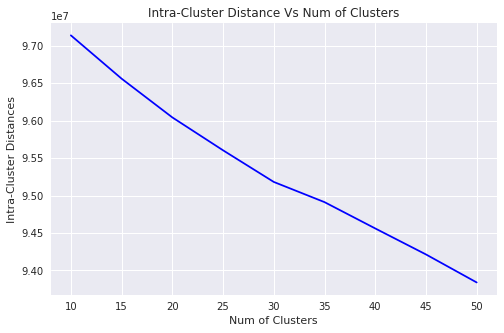

In [16]:
find_best_k(fitted_models)

#### Observation: 
* From Intra-Cluster Distance vs Num of Clusters graph it seems as the number of cluster increased the model clusters the data more properly. And the curve is some-what linear so I'm stopping at 50 clusters.

In [17]:
# select the model with 50 clusters 
cluster50 = fitted_models[8]

### [B] Manual Checking of Some Clusters

In [22]:
sorted_data[:100000]['Text'][cluster50.labels_ == 2]

845       I don't know why anyone would ever use those l...
3402      Pierre Robert is similar to Brie but with a sm...
3328      As much as my family and I love cheese from It...
3708      This is the powdered dried cheese like in &quo...
6745      ...I've never written a product review before,...
1447      Both my cats have a good quality dry food as t...
15117     I recently ordered several cakes for my busine...
11720     What an outstanding spice blend!!!  It will al...
17763     While preparing for a friend's birthday party ...
5838      Isn't this SHRIMP the perfect pink for Valenti...
22260     I purchased 15 of these for my 7 year-old's bi...
12658     When I was in catering one of the most extrava...
288       I love this film.  Barbara and Adam Maitland, ...
4647      Hands down the god of snackfood.<br /><br />Th...
13312     OK, its an acquired taste, but fun. It can be ...
3302      Any type of cheese from iGourmet is excellent,...
22022     The Napolitains are wonderful 

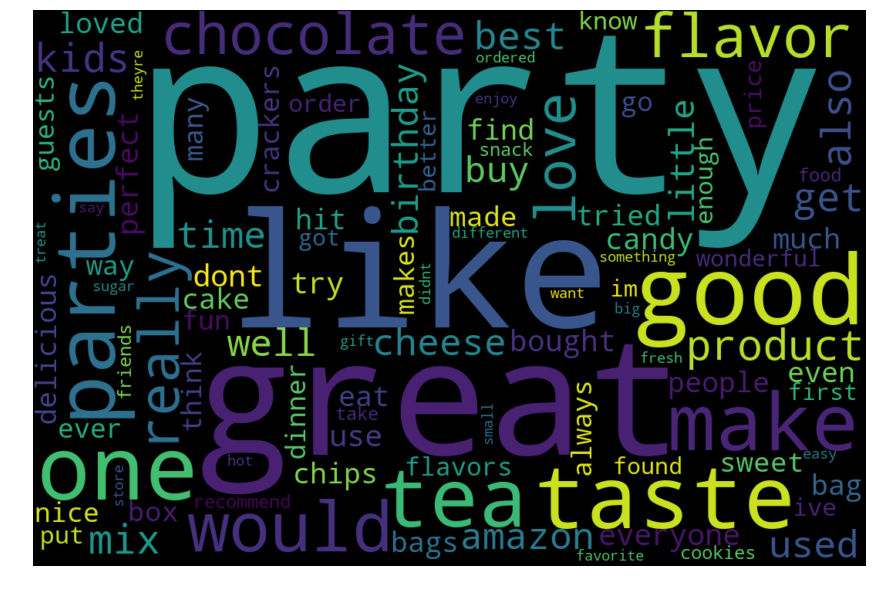

In [48]:
print_word_cloud(sorted_data[:100000]['Text'][cluster50.labels_ == 2].values)

#### Observation: 
* In this cluster we can notice that the reviews talks about party and food products used in parties.

In [49]:
sorted_data[:100000]['Text'][cluster50.labels_ == 17]

209365    For me, when the days get colder nothing is as...
3564      Blend a little apple cider mix into your Tazo ...
3506      "There are few hours in life more agreeable th...
3524      "A single cup of Tazo Calm has been known to h...
2984      So many black teas (such as pu-erh and yunnan)...
2224      It absolutely amazes me that some people spend...
60858     My search for a good all-purpose decaffeinated...
2929      I am a tea lover.  I won't touch coffee, not e...
13271     Sing in me oh muse on this snow day, and let m...
3481      My first Tazo experience included a box of int...
8790      My first Tazo experience included a box of int...
2726      This is a great "tea".  Technically, it's not ...
20056     I have been a fan of Lipton's tea for more tha...
21692     A Ming Dynasty (AD 1368 - 1644) creation belie...
6562      Unquestionably the most refined of teas, Darje...
3598      This is the story of two Tazo teas. I found th...
34742     Researchers in Taiwan have fou

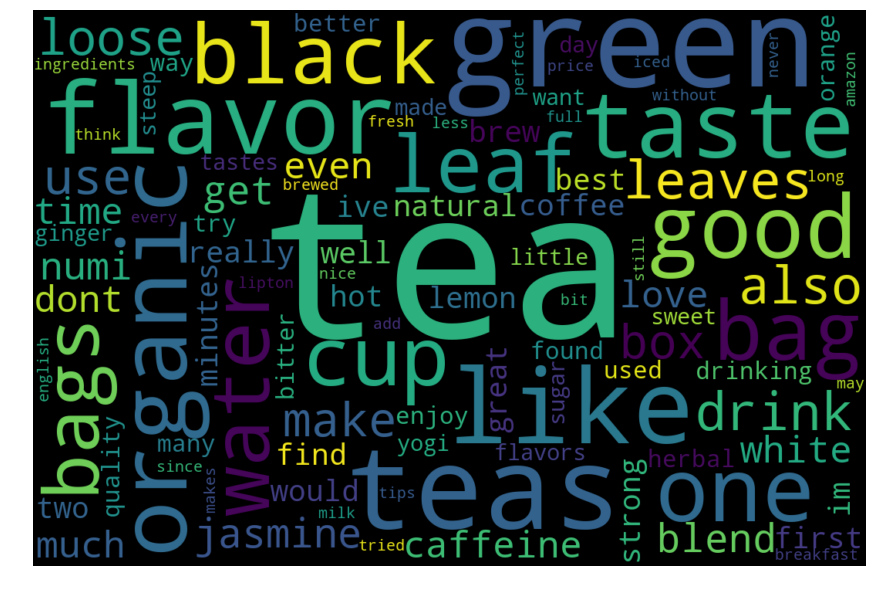

In [50]:
print_word_cloud(sorted_data[:100000]['Text'][cluster50.labels_ == 17].values)

#### Observation: 
* In this cluster most reviews are about tea and various flavors of tea like dark tea, green tea, organic tea etc.

In [51]:
sorted_data[:100000]['Text'][cluster50.labels_ == 37]

20627     This review is written for Pill Pockets for Ca...
90829     ...and I did.  My cat was diagnosed with asthm...
115258    My dog Andy requires 3 pills 3 times a day. I ...
20643     If you have to give your cat pills alot this p...
20626     My cat is pretty laid back, but when it comes ...
90703     Before I found Pill Pockets I had to trick, en...
20645     I cannot believe how unbelievably simple these...
20630     Our cat is pretty mellow with the exception of...
20624     My vet told me I had to give my cat anti-bioti...
20625     I realize this review may seem a bit odd, beca...
115289    I have a 100lb dog, an Akita who HATES taking ...
20647     You get a good number of the treats, even thou...
20617     I have being pilling my cat, Kushka, who has c...
90765     I got a prescription for Cosequin capsules for...
90835     I have struggled for over a year and a half in...
90764     I am extremely happy with Pill Pockets for Cat...
90714     These are awesome.  Not knowin

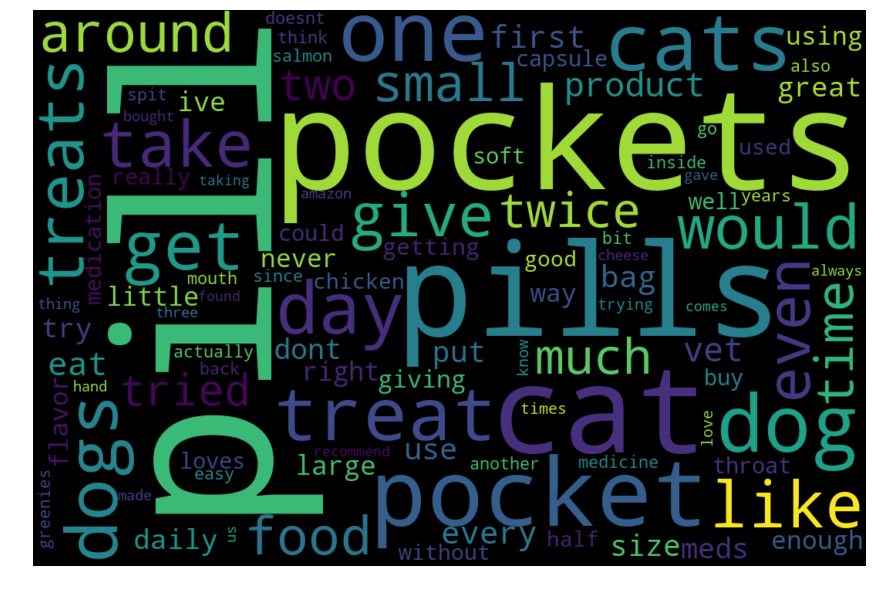

In [52]:
print_word_cloud(sorted_data[:100000]['Text'][cluster50.labels_ == 37].values)

#### Observation: 
* This cluster is about medication for pets, vet and products related to it.  

### 6.2. Hierarchical Clustering

In [53]:
fitted_models = Hierarchical_cluster(sorted_data.iloc[:5000], count_vect, 'BoW')

In [54]:
# taking 10 clusters into consideration
cluster10 = fitted_models[8]

### [A] Manual Checking of Some Clusters

In [61]:
sorted_data[:5000]['Text'][cluster10.labels_ == 0]

1119      Finally, a collection of the best Camper Van B...
2290      Few things I'd like to point out:<p>1.  &quot;...
3428      If you've never had real Swiss fondue, you're ...
3328      As much as my family and I love cheese from It...
3564      Blend a little apple cider mix into your Tazo ...
3060      Panko bread crumbs are just awesome.  When use...
4682      I recently purchased a bag of Kookaburra Black...
3506      "There are few hours in life more agreeable th...
4604      Blair isn't joking: that plastic skull is a co...
3524      "A single cup of Tazo Calm has been known to h...
163001    "Sitting on the porch of a bungalow on a tea p...
8634      Organic Sucanat is many levels above regular w...
10914     I have been drinking Douwe Egberts red label c...
10679     Douwe Egberts makes some of the most delicious...
10916     The Millstone and Folgers pods for the Home Ca...
10571     After spending 2 weeks in the Netherlands last...
150475    Having received some Blue D'Au

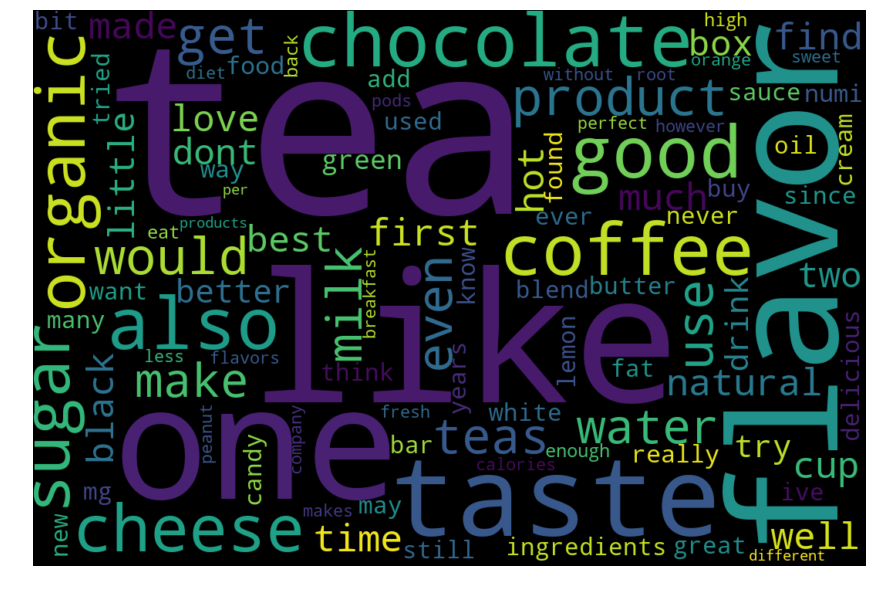

In [62]:
print_word_cloud(sorted_data[:5000]['Text'][cluster10.labels_ == 0].values)

#### Observation: 
* This cluster is about drinks like tea, coffee and various other things related to these two. Other than that it has also some noise like cheese, oil and sauce etc. 


In [59]:
sorted_data[:5000]['Text'][cluster10.labels_ == 8]

19141    JUICY JUICE'S MISSION: STOP BUYING SODA FOR YO...
19104    TASTES LIKE THIS CAN'T POSSIBLY BE 100% JUICE!...
19020    JUICY JUICE'S MISSION: STOP BUYING SODA FOR YO...
77171    A NEW PRODUCT FROM JUICY JUICE IS ANOTHER WINN...
Name: Text, dtype: object

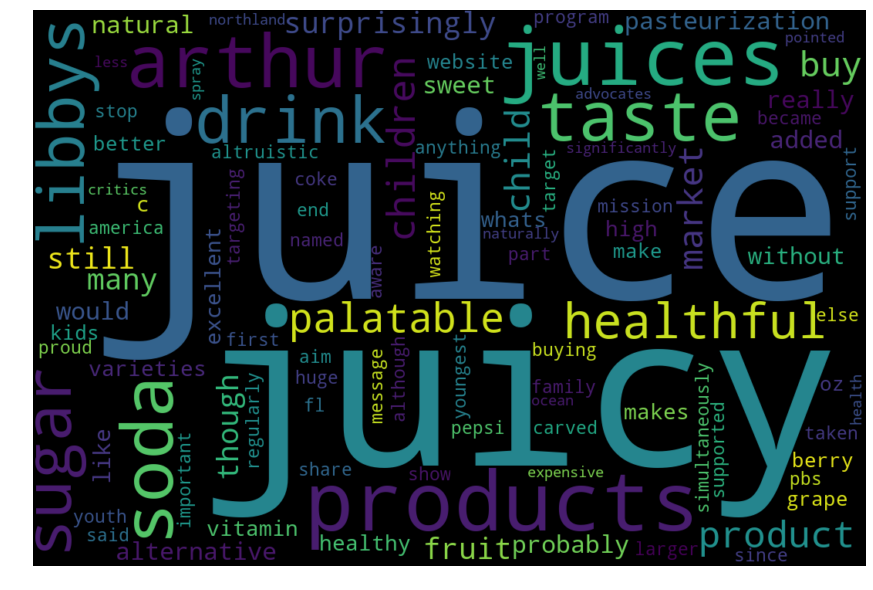

In [60]:
print_word_cloud(sorted_data[:5000]['Text'][cluster10.labels_ == 8].values)

#### Observation: 
* This small cluster is about juice related products including carbonated juice.

## 7. TF-IDF

In [63]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(min_df = 0, max_features = 1000)

### 7.1. K-means Clustering

In [64]:
fitted_models_tfidf = kmean_cluster(sorted_data.iloc[:100000], tf_idf_vect, 'TFIDF')

### [A] Find Best-Fit K

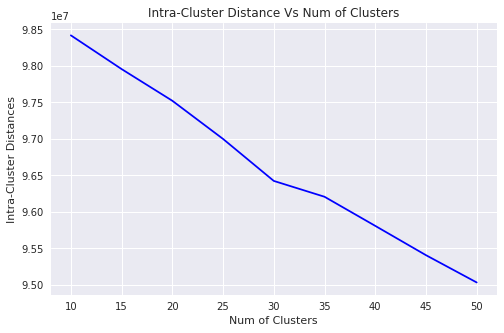

In [65]:
find_best_k(fitted_models_tfidf)

#### Observation: 
* From Intra-Cluster Distance vs Num of Clusters graph it seems as the number of cluster increased the model clusters the data more properly. And the curve is some-what linear so I'm stopping at 50 clusters.

In [66]:
# taking 50 clusters into account 
tfidf_cluster50 = fitted_models_tfidf[8]

### [B] Manual Checking of Some Clusters

In [71]:
sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 0]

1032      Although this was a gift to use for keeping wi...
6956      I discovered these oils years ago, bought one ...
6264      This is a FANTASTIC product. If you are a blue...
17627     Recently purchased Anchovy Stuffed Olives.  It...
1072      The Concerto worked well for about the first 5...
19111     Mt. Olive has topped itslef with this pickle a...
3715      My best friend turned me on to Cavender's back...
11702     These salty jumbo olives are great in a martin...
18804     Couscous is a wonderful alternative for the ca...
10381     I like to keep crunchy snacks that aren't swee...
31129     Extra virgin olive oil from the region Liguria...
19851     WHY THIS SIZE:<br /><br />If you are not going...
3361      I ordered this for my sister's Xmas gift. I wa...
3085      What rhymes with Dipper? Pipper!!! And Ol' Dip...
20104     I found this in my local supermarket (publix -...
26586     This olive oil is by far the best I've ever ta...
28706     I love this coconut oil. It ta

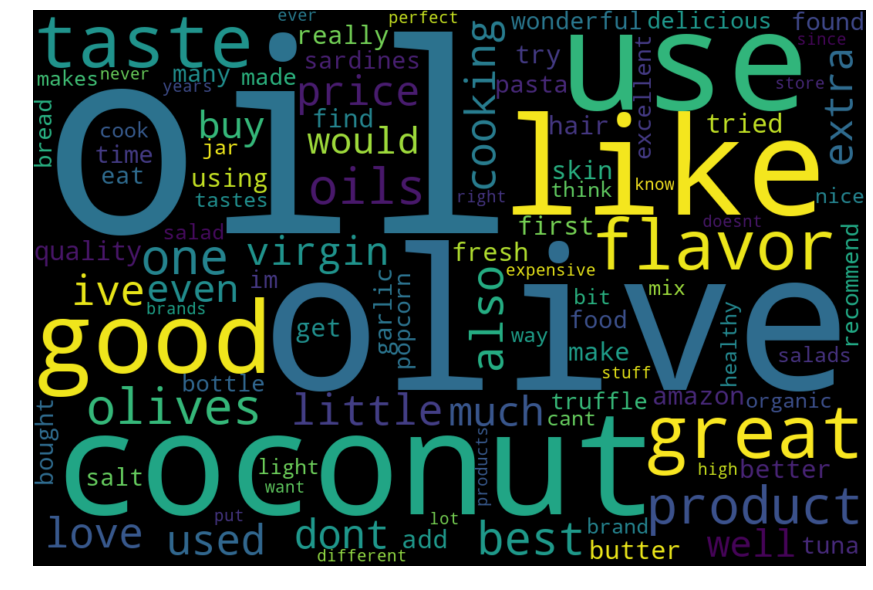

In [72]:
print_word_cloud(sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 0].values)

#### Observation: 
* This cluster is about various oil products like olive oil, coconut oil etc.

In [73]:
sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 21]

2678      "We use and believe in stone milling because n...
2681      "We use and believe in stone milling because n...
31027     Second special praise and worship collection f...
47563     Xanthan gum is the key to (most) gluten-free b...
47001     Bob's Red Mill is a reliable and inexpensive s...
46060     The biggest pain to making authentic hummus fr...
45838     They were thick, like Bisquick biscuits. They ...
45823     They are good in cereal (Bob's Red Mill Muesli...
46965     Bob's Red Mill Roasted Oregon Hazelnuts tasted...
23562     I've tried this and it seems to be both better...
46377     I've been eating Famila unsweetened muesli for...
46997     I can't eat any kind of wheat flour, but since...
64815     But the taste is wonderful. Toss in some Bob's...
64819     I'm so glad to see Hodgson Mills products here...
48393     A really high quality cookie with a delicate t...
46413     I've tried many different brands of Muesli and...
45912     I use oat bran both as a hot c

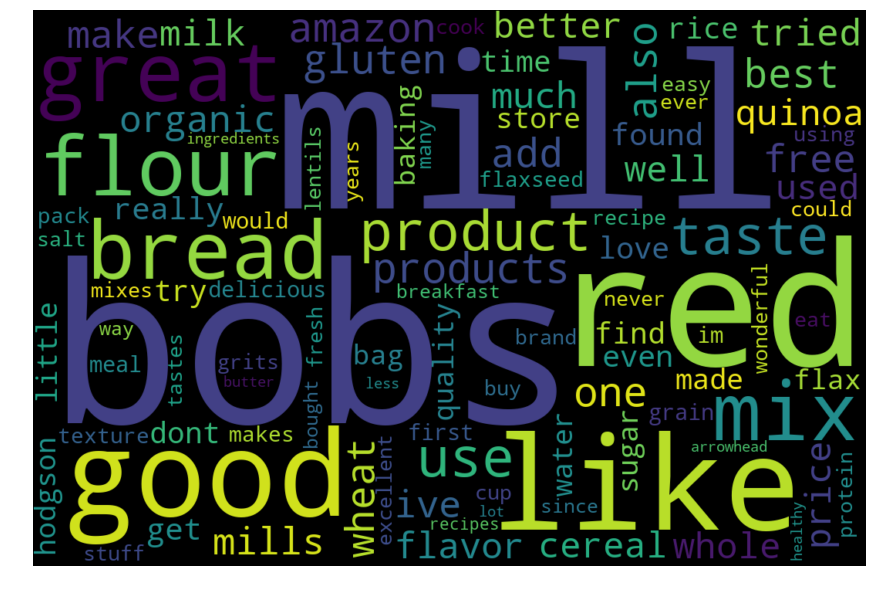

In [74]:
print_word_cloud(sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 21].values)

#### Observation: 
* This cluster is all about mill products, grains and food items made of grains etc. And it mostly talks about bobs mill. 

In [79]:
sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 47]

4575      These are kind of like gummy bears, except the...
55934     The top of the frogs have a slight lime taste ...
4655      These are a great gummy candy because their co...
56569     These letters are a nice simple gummy. They ar...
4652      I'm not the sort of man to sit around and argu...
4647      Hands down the god of snackfood.<br /><br />Th...
27188     These are GREAT!<br /><br />It's just like dri...
28550     Oh I love these candy! They are gummy (chewy) ...
4565      My fruit slices came in the hot weather.  Inst...
39359     These sugar worms are incredibly addictive, an...
35471     Here's the trick.  If you zap it on the ground...
56402     I spent the first 8 years of my life in German...
56361     We bought two of these to use as favors for a ...
56182     I got these, along with a book, for my husband...
56873     I, like some of the other reviewers, had a nas...
56513     Always one of my favorite Haribo gummi candies...
57007     i enjoy my sweets, and the har

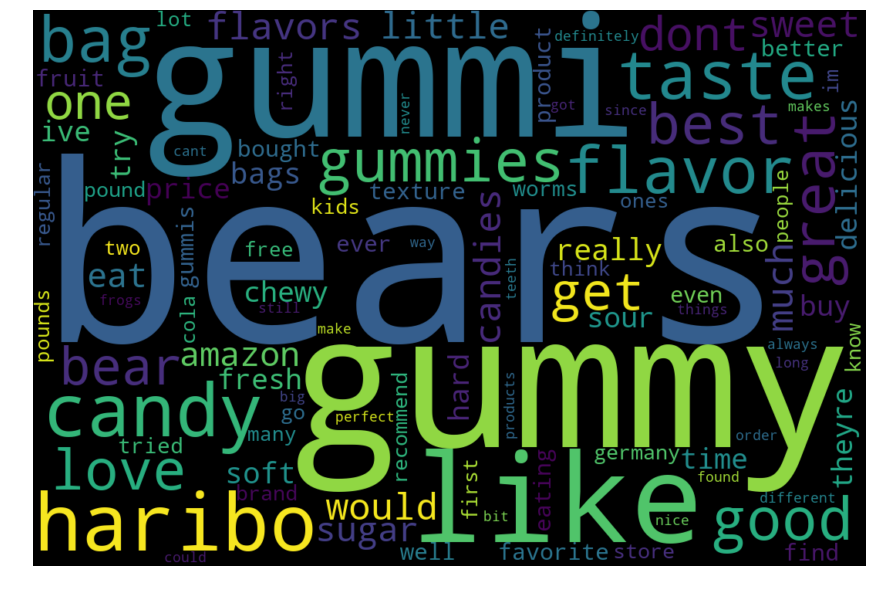

In [80]:
print_word_cloud(sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 47].values)

#### Observation: 
* This cluster is completely about candies. Mostly it's about gummy bears candy. 

### 7.2. Hierarchical Clustering

In [81]:
fitted_models_tfidf = Hierarchical_cluster(sorted_data.iloc[:5000], tf_idf_vect, 'TFIDF')

In [82]:
# taking 10 clusters into consideration
tfidf_cluster10 = fitted_models_tfidf[8]

### [A] Manual Checking of Some Clusters

In [83]:
sorted_data[:5000]['Text'][tfidf_cluster10.labels_ == 6]

3708      This is the powdered dried cheese like in &quo...
19385     Some of us should be warned about two importan...
19383     Macaroni and Cheese Purists will NOT like this...
20096     I see that someone using my name is advocating...
343931    This stuff is great on rice and beans, and on ...
18611     Parmesan cheese has been a favorite of mine si...
21358     My dog Annie had surgery about 2 months ago an...
25295     I like organic. We do organic milk and meat (a...
25287     I like organic. We do organic milk and meat, a...
19386     I was a kid raised on Kraft macaroni and chees...
25284     We are trying to eat more healthy and organic ...
37054     Annie's Deluxe macaroni and cheese comes with ...
41063     My kids love their Macaroni & Cheese but one d...
37056     My children and I agree: this is the best tast...
36485     This is the best everyone! I can eat the whole...
36759     I absolutely love this mac and cheese it is di...
37074     We stopped buying the Kraft ma

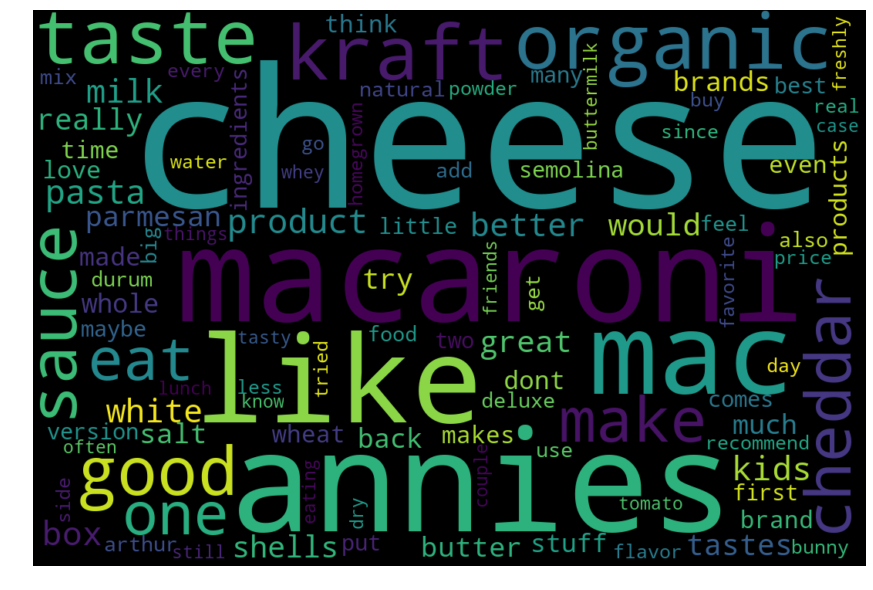

In [84]:
print_word_cloud(sorted_data[:5000]['Text'][tfidf_cluster10.labels_ == 6].values)

#### Observation: 
* This one here is about various cheese, macaroni, sauce, pasta and butter. So, it seems like various Italian foods. 

In [85]:
sorted_data[:5000]['Text'][tfidf_cluster10.labels_ == 1]

998       For years I have been trying to simulate a tru...
994       Using the Briel Chamonix machine I purchased f...
1003      After years of using Starbuck's decaf and regu...
2290      Few things I'd like to point out:<p>1.  &quot;...
5907      If you've never tried Kona coffee, Aloha Islan...
2941      Many coffee brands that advertise their beans ...
1005      We ordered these to go with our new espresso m...
6628      Hawaii Roasters is definitely the best coffee ...
6618      I have been drinking coffee for well over twen...
10914     I have been drinking Douwe Egberts red label c...
10967     I am trying to find out if these Senseo pods w...
10679     Douwe Egberts makes some of the most delicious...
10560     The Senseo machine shipped with two 18-pod sam...
10916     The Millstone and Folgers pods for the Home Ca...
10571     After spending 2 weeks in the Netherlands last...
10959     The Douwe Egberts dark roast is the best of al...
10479     On a recent trip to Holland I 

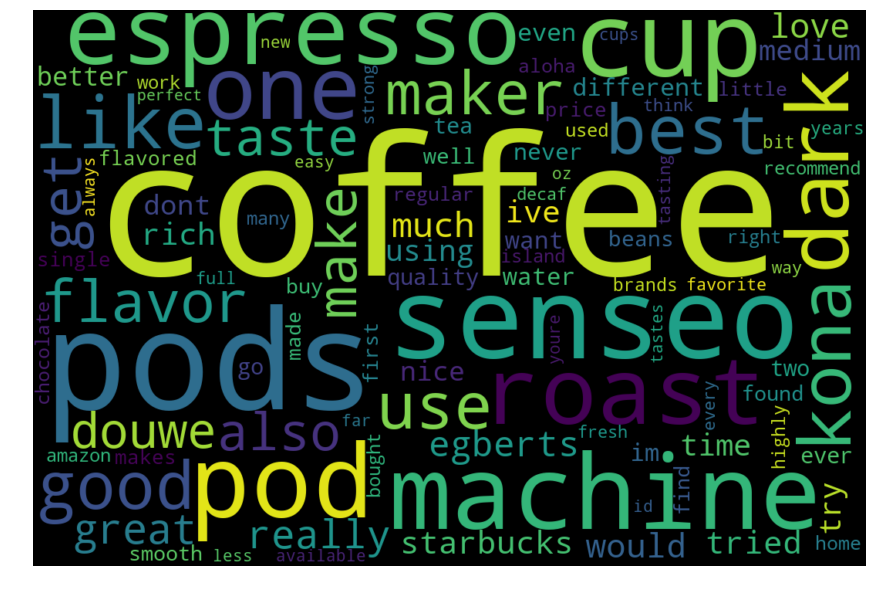

In [86]:
print_word_cloud(sorted_data[:5000]['Text'][tfidf_cluster10.labels_ == 1].values)

#### Observation: 
* This cluster is all about coffee, coffee shop, coffee related products and coffee making machines.

## 8. Word2Vec

In [17]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [18]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data[:100000]['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

## 9. Average Word2Vec

In [19]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

### 9.1. K-means Clustering

In [92]:
fitted_models_w2v = kmean_cluster(data = None, vectorizer = None, data_in_list = list_of_sent, name = 'Word2Vec')

### [A] Find Best-Fit K

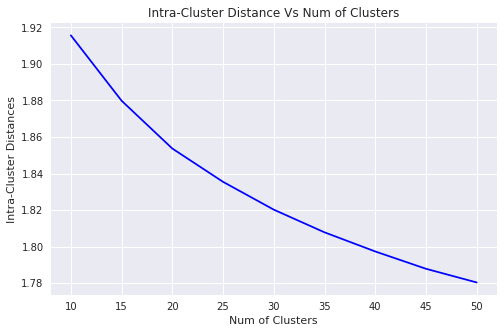

In [93]:
find_best_k(fitted_models_w2v)

In [94]:
w2v_cluster50 = fitted_models_w2v[8]

### [B] Manual Checking of Some Clusters 

In [110]:
sorted_data[:100000]['Text'][w2v_cluster50.labels_ == 11]

4945      They're shaped like Legos and they taste like ...
15401     They look and smell like human cookies so keep...
7104      These are amazingly flaky, deliciously sweet w...
21343     My three dogs love it and so do all the cats!!...
4427      My wife and I are both milk intolerant. There ...
20854     These are the best for keeping your dog happy!...
7495      These truffles are really great--I was skeptic...
5122      these things are really great....they are hot,...
24602     If you are on Weight Watchers, there is no bet...
24889     These are a real flashback! And they taste jus...
26374     Absolutely delicious, rich, cocoa-coated choco...
10743                                    they are excellent
31291     Noodles are low cal and low carb and it is har...
31278     40 calories for 8 oz of noodles.  They are del...
6193      My cats are addicted to this stuff!  They actu...
26429     Thses sprats were clearly fresh and far surpas...
51654     haven't tried cooking with the

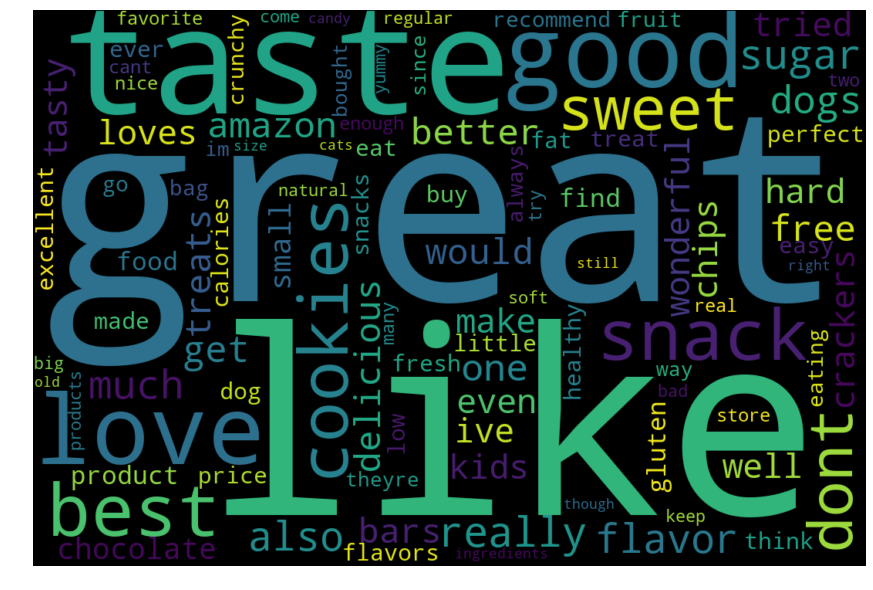

In [109]:
print_word_cloud(sorted_data[:100000]['Text'][w2v_cluster50.labels_ == 11].values)

#### Observation: 
* This cluster is about food items related to snacks and maximum of the reviews seem to be positive. 

In [121]:
sorted_data[:100000]['Text'][w2v_cluster50.labels_ == 39]

5907      If you've never tried Kona coffee, Aloha Islan...
2293      This blend is one of Starbucks' gentler blends...
6618      I have been drinking coffee for well over twen...
2292      Starbucks coffee is in my opinon second to non...
5023      I tried this ONCE and expected something out o...
10914     I have been drinking Douwe Egberts red label c...
10679     Douwe Egberts makes some of the most delicious...
2241      This coffee rivals the name brand coffee house...
10571     After spending 2 weeks in the Netherlands last...
10493     I must respectfully disagree with the other re...
10921     The Dark Roast is the best of the coffee pods ...
89834     When I am not being seduced by the "Breakfast ...
17638     I was thrilled to find Kona coffee in pods for...
10519     This coffee machine is probably the best coffe...
10915     The coffee machine is probably the best coffee...
10529     I have had my Senseo for a little over a week....
995       These pods have got to be the 

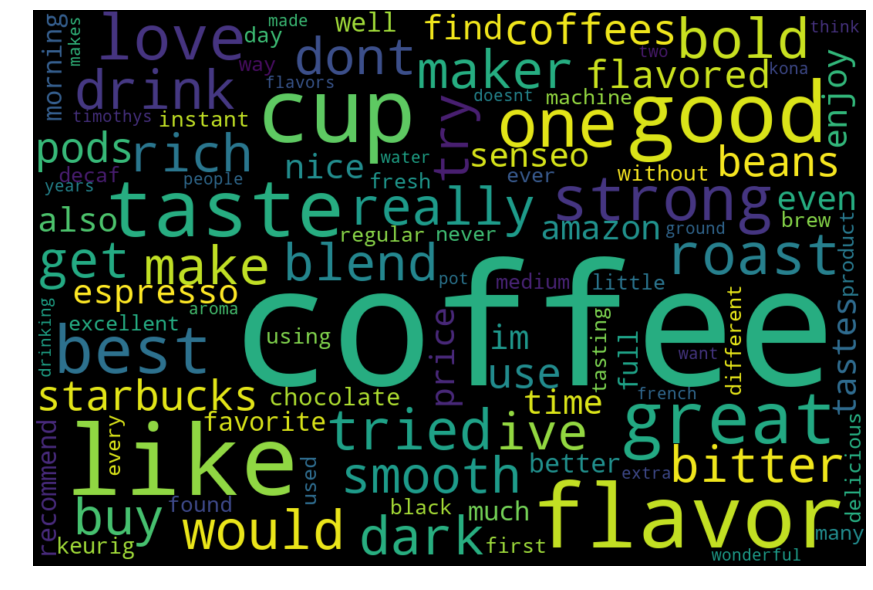

In [119]:
print_word_cloud(sorted_data[:100000]['Text'][w2v_cluster50.labels_ == 39].values)

#### Observation: 
* This cluster is about coffee and various flavors of coffee.

### 9.2. Hierarchical Clustering

In [120]:
fitted_models_w2v = Hierarchical_cluster(list_of_sent[:5000], None, 'Word2Vec')

In [122]:
# taking 10 clusters into consideration
w2v_cluster10 = fitted_models_w2v[8]

### [A] Manual Checking of Some Clusters 

In [137]:
sorted_data[:5000]['Text'][w2v_cluster10.labels_ == 4]

325       I'm getting crazy.I'm looking for Beatlejuice ...
427       I'm getting crazy.<p>Is it really impossible t...
242       I just received my shipment and could hardly w...
485       I have just recently purchased the Woodstream ...
249       This is such a great film, I don't even know h...
425       Michael Keaton brings no distinguishing charac...
1065      I was very skeptical when I bought this item, ...
1053      I have used both this product and the standard...
1032      Although this was a gift to use for keeping wi...
357315    I love meow mix, my cats love it to. We all ea...
5289      Chipotle makes everything taste better.  I fir...
5933      When chatchi's favorite afternoon treat became...
2217      A tennis player hubby of mine got this pack on...
4431      I have baked with this organic vanilla in the ...
2993      If you like Earl Grey tea, you'll find no bett...
3659      While Pesto Genovese is my favorite pesto for ...
4696      I like this flavor, but it kin

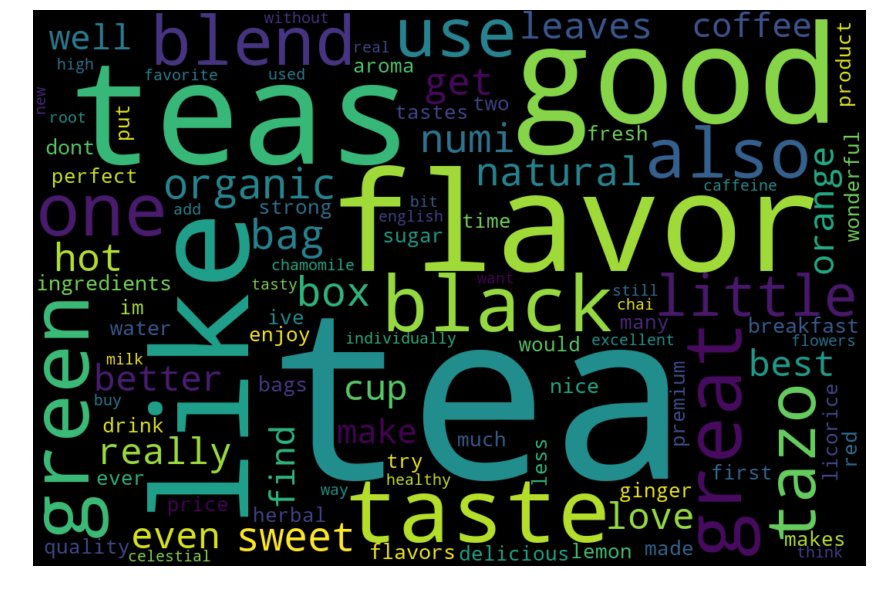

In [136]:
print_word_cloud(sorted_data[:5000]['Text'][w2v_cluster10.labels_ == 3].values)

#### Observation: 
* This one clusters tea products, tea flavors and most of them talk about tea product from the brand named 'tazo'.

In [143]:
sorted_data[:5000]['Text'][w2v_cluster10.labels_ == 0]

261       What happens when you say his name three times...
837       This are so much easier to use than the Wilson...
868       These are easy to use, they do not make a mess...
867       For those wondering, the bottles are each 3/4 ...
3716      Forget that store bought jerky.  Make your own...
7493      These Truffles are the absolute best tasting t...
3060      Panko bread crumbs are just awesome.  When use...
3061      This is the Japanese version of breadcrumb (pa...
5837      I wanted to order something from the gourmet f...
231731    My wife and I are dark chocolate snobs (Scharf...
7192      These chocolates are the most perfect containe...
4945      They're shaped like Legos and they taste like ...
8829      I bought several items from Barry Farms, all o...
15114     These coffee cakes make great gifts for any ac...
4994      This is the worst dried mango product. I taste...
4995      This is the worst dried mango product. I taste...
2042      We fed this food to both of ou

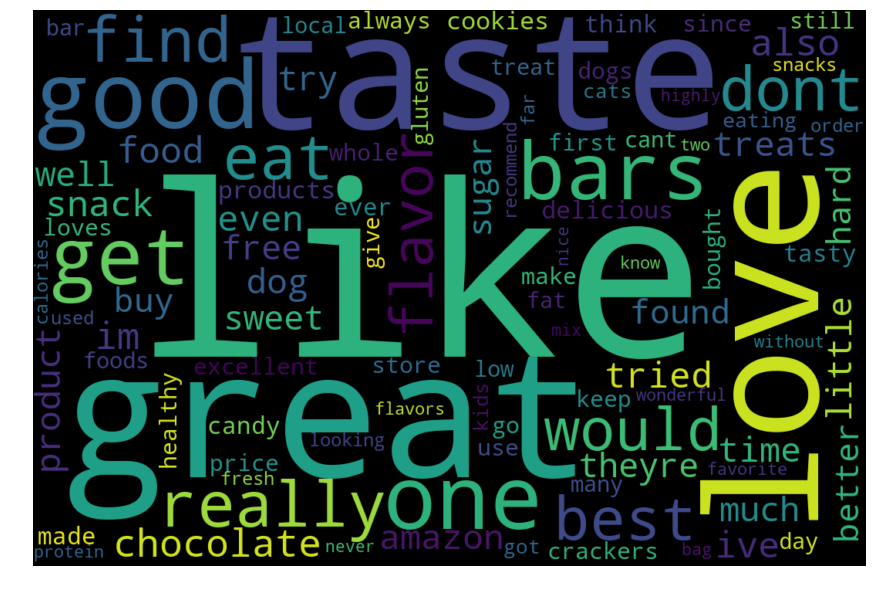

In [142]:
print_word_cloud(sorted_data[:5000]['Text'][w2v_cluster10.labels_ == 0].values)

#### Observation: 
* This cluster is about chocolate, crackers, snacks and some food items liked by dogs etc.

### 9.3. DBSCAN Clustering

### [A] Find Best-Fit Eps 

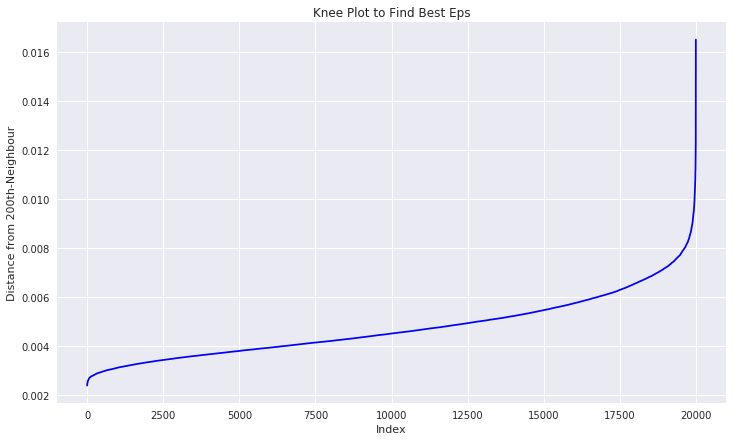

In [144]:
best_eps(list_of_sent[:20000], 'Word2Vec')

#### Observation: 
* From this plot the best-fit eps seems to be 0.01 as after that the distance from 200th nearest neighbor increases drastically.

In [20]:
cluster = DBSCAN_cluster(sorted_data[:20000]['CleanedText'], name = 'Word2Vec',best_eps = 0.01, data_in_list = list_of_sent[:20000])

In [21]:
np.unique(cluster.labels_)

array([-1,  0])

In [22]:
(cluster.labels_ == -1).sum()

17

In [23]:
(cluster.labels_ == 0).sum()

19983

In [31]:
sorted_data[:20000]['Text'][cluster.labels_ == -1].values

array(['I just love this sauce. I put in on everything.',
       'I buy this at our neighborhood supermarket.  It really is the best soymilk - best flavor, best texture, everything.',
       "My brother-in-law was thrilled with this gift (and he's Italian!).<br />&gt; Superfast shipping!",
       ...,
       'Although both Sugar Twin and Sweet and Low both use saccharine, Sugar Twin has a much better taste.',
       'There is NO KASHI at all!!!<br />Instead;<br />35 Special K<br />25 Smart Start<br />Deceived.',
       'It taste great...I love drinking it in the morning when i am off to work!'],
      dtype=object)

#### Observation:
* These reviews are marked as noisy data-points by this DBSCAN model with eps = 0.01.

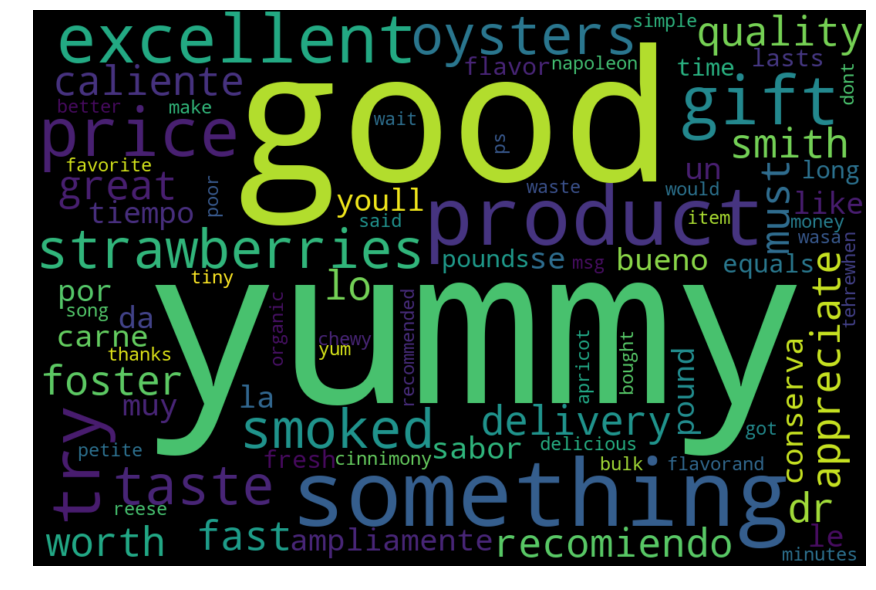

In [25]:
print_word_cloud(sorted_data[:20000]['Text'][cluster.labels_ == -1].values)

#### Observation:
* And these are the most commonly used words in the noisy data-points.

### [B] Experiment with other eps values

In [27]:
cluster = DBSCAN_cluster(sorted_data[:20000]['CleanedText'], name = 'Word2Vec',best_eps = 0.006, data_in_list = list_of_sent[:20000])

In [28]:
np.unique(cluster.labels_)

array([-1,  0])

In [29]:
(cluster.labels_ == -1).sum()

1672

In [30]:
(cluster.labels_ == 0).sum()

18328

In [32]:
cluster = DBSCAN_cluster(sorted_data[:20000]['CleanedText'], name = 'Word2Vec',best_eps = 0.005, data_in_list = list_of_sent[:20000])

In [33]:
np.unique(cluster.labels_)

array([-1,  0])

In [34]:
(cluster.labels_ == -1).sum()

4349

In [35]:
(cluster.labels_ == 0).sum()

15651

#### Observation: 
* Along with the best-eps I tried other possible eps values to illustrate how DBSCAN clustering is so much sensitive to the eps value.
* For eps = 0.006, 1672 data points are marked as noisy points and rest are clustered together to form a single cluster.
* For eps = 0.005, 4349 points are marked as noisy i.e only 0.001 change in eps brings 3 times change in number of noisy points. It clearly shows even a small change in eps ends with drastic change in clustering.

## 10. TFIDF - Word2Vec

In [36]:
tf_idf_vect = TfidfVectorizer()

In [37]:
from tqdm import tqdm

# Determining TF-IDF weighted Word2Vec
def tfidf_w2v(data, model, dictionary):
    tfidf_feat = tf_idf_vect.get_feature_names() 
    tfidf_sent_vectors = []
    row = 0
    for sent in tqdm(data): 
        sent_vec = np.zeros(100)
        weight_sum = 0 
        for word in sent: 
            try:
                vec = model.wv[word]
                tf_idf = dictionary[word] * (sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return np.matrix(tfidf_sent_vectors)

### 10.1. K-means Clustering

In [84]:
models_tfidf_w2v = kmean_cluster(sorted_data[:100000]['CleanedText'], None, 'TFIDF-W2V', list_of_sent)

100%|██████████| 100000/100000 [00:36<00:00, 2732.29it/s]


### [A] Find Best-Fit K

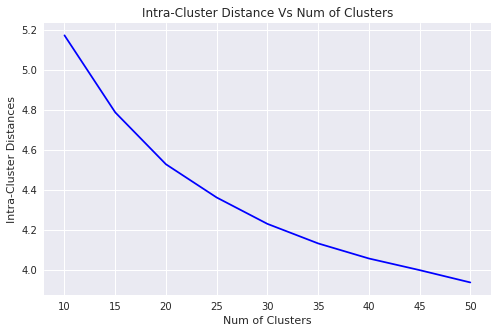

In [85]:
find_best_k(models_tfidf_w2v)

In [86]:
tfidf_w2v_cluster50 = models_tfidf_w2v[8]

### [B] Manual Checking of Some Clusters  

In [90]:
sorted_data[:100000]['Text'][tfidf_w2v_cluster50.labels_ == 21]

5095      We got Linda's Lollies at our office a few wee...
7192      These chocolates are the most perfect containe...
7103      If you haven't tried these you need to now!<p>...
5827      We have certainly exjoyed this variety pack of...
997       I can't say enough good things about the Espre...
7100      These twists are so good you wouldn't believe ...
5070      These hard, yet chewable sweets are akin to th...
7088      Pickles like these can be very much an acquire...
16740     A friend who owns a pet store recomended Bil-J...
156237    These are the BEST wasabi peas I have ever tri...
4575      These are kind of like gummy bears, except the...
4189      Beautifully pruned tree.  Picture does not do ...
3310      Since moving to the US from England, there are...
19075     After receiving a gift of delicious blueberry ...
17148     These pods are very expensive, but the taste i...
26543     fabulous, low-carb sugarfree cookies.  No afte...
16975     I wish I could rate this  100 

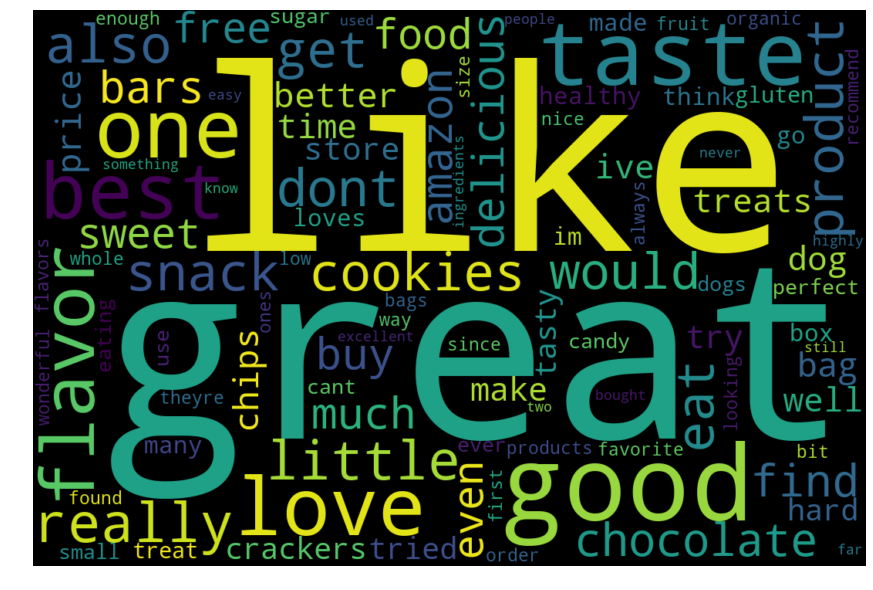

In [91]:
print_word_cloud(sorted_data[:100000]['Text'][tfidf_w2v_cluster50.labels_ == 21].values)

#### Observation: 

* This cluster is about various snacks like cookies, crackers, chocolates and all the reviews are mostly positive.

In [117]:
sorted_data[:100000]['Text'][tfidf_w2v_cluster50.labels_ == 27]

30        I can remember seeing the show when it aired o...
6381        I just love this sauce. I put in on everything.
5194      In the winter when fresh blueberries exceed ou...
2976      $13.95 in shipping (5-7 days) for a $26.00 ord...
13451     I don't recall how we got started on Cholula, ...
16986     This stuff tastes just like Sweettarts.  I rec...
3467      Several years ago, at a loss for what to get m...
7613      Great to use as a dry rub on tri-tip steak. Wo...
112398    I thought we were doomed to another night of b...
22133     I have never opened a bag of Nori Maki Arare w...
11683     Saw this advertised on Oprah, and I must say s...
18753     This is so cool that you can review food on Am...
25159     My husband puts this on steaks (not just porte...
11687     I saw this first on Oprah and it is every bit ...
22282     Another treat from Willy Wonka, this stretchy ...
6278      What a treat....sweet, hot,but not too hot.......
31723     THE BEST SAUCE YOU COULD EVER 

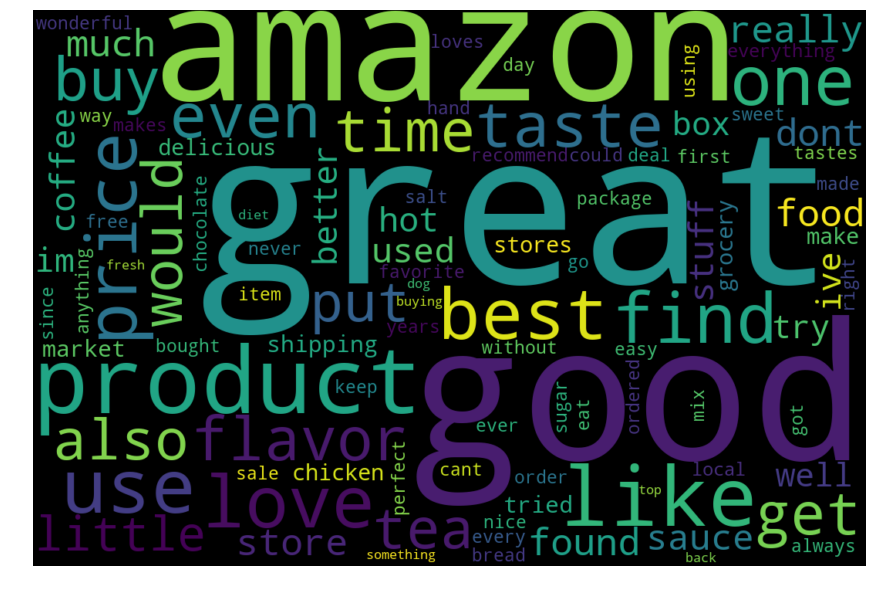

In [116]:
print_word_cloud(sorted_data[:100000]['Text'][tfidf_w2v_cluster50.labels_ == 27].values)

#### Observation: 
* This cluster consists of positive reviews about various products that are provided by amazon.

### 10.2. Hierarchical Clustering

In [118]:
models_tfidf_w2v = Hierarchical_cluster(sorted_data.iloc[:5000],  None, 'TFIDF-W2V', list_of_sent[:5000])

100%|██████████| 5000/5000 [00:00<00:00, 8818.07it/s]


In [119]:
# considering 10 clustered model
cluster10 = models_tfidf_w2v[8]

### [A] Manual Checking of Some Clusters

In [132]:
sorted_data[:5000]['Text'][cluster10.labels_ == 1]

331       When vacationing Adam and Barbara Maitland mee...
311       When Two Couple (Geena Davis & Alec Baldwin) d...
259       Set in a small New England town, Tim Burton's ...
299       Beetlejuice is the story of ghosts (Alec Baldw...
255       Really, this is one of the strangest movies I'...
10433     I just finished watching this train wreck and ...
258       Here's the plot of 1988's "Beetlejuice", signi...
84552     No question, this is an effective product. Usi...
191421    These prunes are delicious! The great thing ab...
66371     Having consumed Himalania Goji Berries for ove...
Name: Text, dtype: object

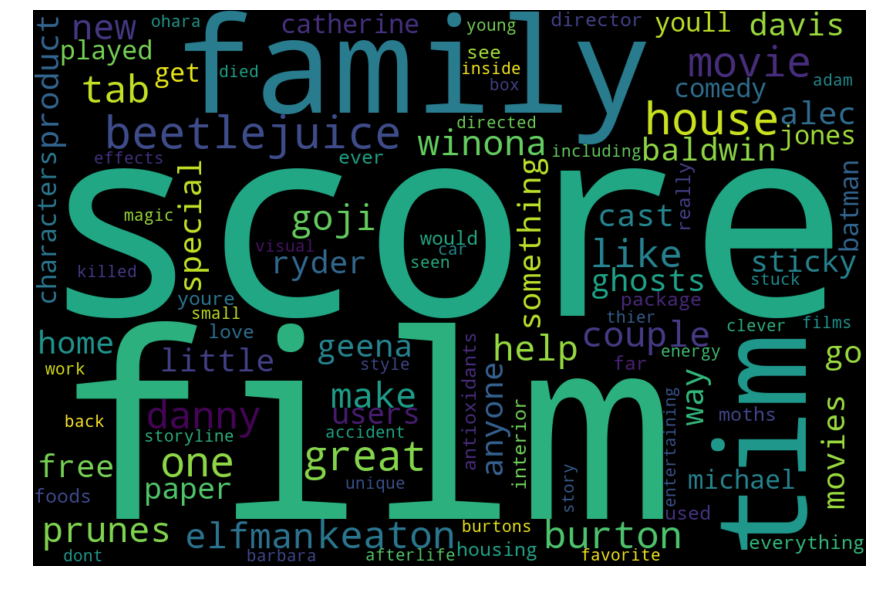

In [122]:
print_word_cloud(sorted_data[:5000]['Text'][cluster10.labels_ == 1].values)

#### Observation: 
* This cluster contains reviews which talk about various movies, movie genre, director and actor of film and things related to films.

In [137]:
sorted_data[:5000]['Text'][cluster10.labels_ == 3]

1113      Long live Camper Van Beethoven!! This is a ble...
256       Tim Burton had come off the blockbuster succes...
10668     Why would I spend five bucks per latte (and ta...
253       Re-watching Beetlejuice more than a decade aft...
27198     The "GeniSoy" Protein Shakes have always impre...
4616      I can't believe it happened, but it did: Sudde...
3883      I'm a lawyer, and got this as a gag gift.  Tur...
2479      I can't tell you that I've tried all of Chef P...
22034     If a little dreaming is dangerous, the cure fo...
13176     If it is possible to fall madly in love with a...
22033     Chocolate makes otherwise normal people melt i...
6045      Wow, I whole-heartedly agree with the two othe...
26674     This is the tea I measure all other teas by, t...
4417      This particular foil cutter is the BEST!  It's...
24884     I've been a fan of these little things since I...
2387      "There are few hours in life more agreeable th...
36208     I found these at my local Trad

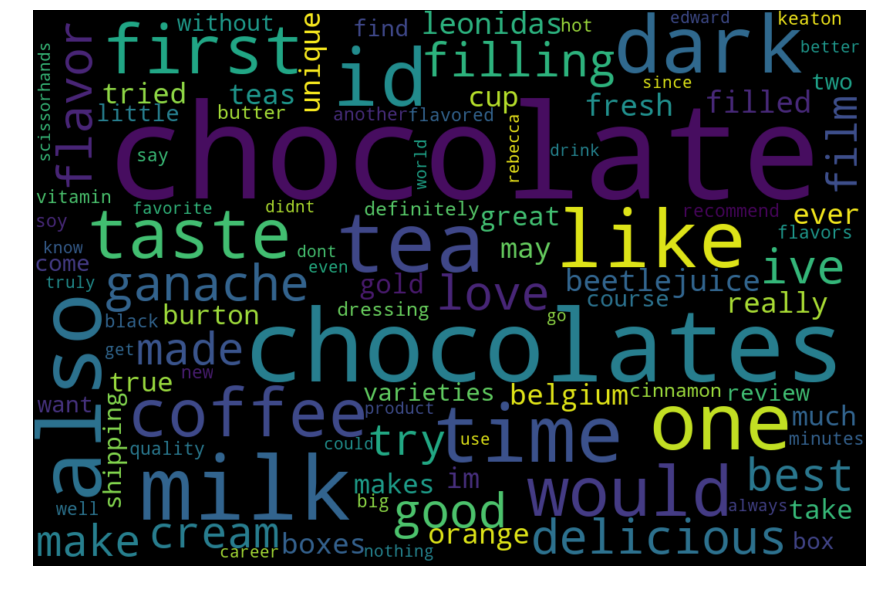

In [136]:
print_word_cloud(sorted_data[:5000]['Text'][cluster10.labels_ == 3].values)

#### Observation: 
* This cluster is bit noisy but most of the reviews are about chocolates. 

### 10.3. DBSCAN Clustering

### [A] Find Best-Fit Eps

100%|██████████| 20000/20000 [00:06<00:00, 3264.89it/s]


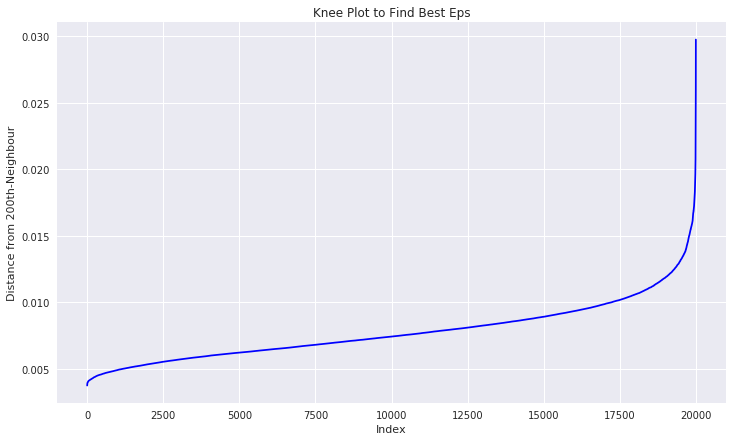

In [138]:
best_eps(sorted_data[:20000]['CleanedText'], 'TFIDF-W2V', list_of_sent[:20000])

#### Observation: 
* From this plot the best-fit eps seems to be 0.015 as after that the distance from 200th nearest neighbor increases drastically.

In [139]:
cluster = DBSCAN_cluster(sorted_data[:20000]['CleanedText'], 0.015, 'TFIDF-W2V', list_of_sent[:20000])

100%|██████████| 20000/20000 [00:06<00:00, 3302.84it/s]


In [140]:
np.unique(cluster.labels_)

array([-1,  0])

In [141]:
(cluster.labels_ == -1).sum()

23

In [142]:
(cluster.labels_ == 0).sum()

19977

In [145]:
sorted_data[:20000]['Text'][cluster.labels_ == -1]

5933      When chatchi's favorite afternoon treat became...
3815      La bourbena e autunno in australia foglio dimm...
42913     The Peach Detox is much better than the plain ...
12420                                          Not worth it
26205        If you appreciate caliente, you MUST try this!
22086     Mmmmm, yummm, mmm, mmmm, slurp, mmmmm, boy, my...
16794     Perfection. Moist. Edges delectably edible. Nu...
2900      Lo recomiendo ampliamente, le da un sabor a la...
21769     Fast response - fast shipping - product exactl...
59633     This is a tolerable tea similar to Twinings.<b...
51326     This was a very good value, compared to retail...
5587      Los dioses Aztecas comian estas galletas! Fabu...
15038     I first tried Vegeta after hearing about it wh...
69464     I really like this product as a sweetner on al...
31575     It is more expensive than Kroger or Meijer. Bo...
49906     This tea changed my life, it finally helped me...
177893    This so called treasure is not

#### Observation:
* These reviews are marked as noisy data-points by this DBSCAN model with eps = 0.015.

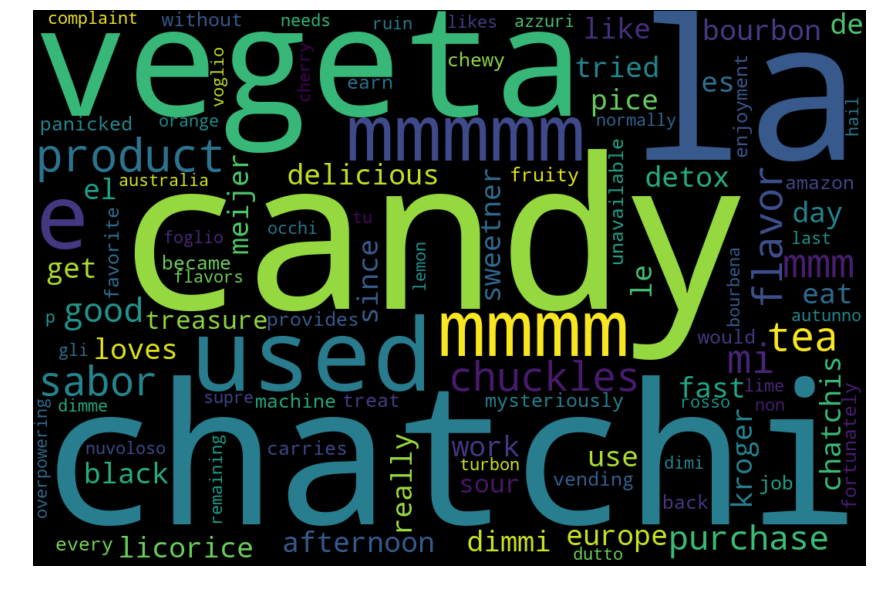

In [143]:
print_word_cloud(sorted_data[:20000]['Text'][cluster.labels_ == -1].values)

#### Observation:
* And these are the most commonly used words in the noisy data-points.

### [B] Experiment with other eps values

In [146]:
cluster = DBSCAN_cluster(sorted_data[:20000]['CleanedText'], 0.01, 'TFIDF-W2V', list_of_sent[:20000])

100%|██████████| 20000/20000 [00:06<00:00, 3283.04it/s]


In [147]:
np.unique(cluster.labels_)

array([-1,  0])

In [148]:
(cluster.labels_ == -1).sum()

626

In [149]:
(cluster.labels_ == 0).sum()

19374

#### Observation: 
* Along with the best-eps I tried other possible eps values to illustrate how DBSCAN clustering is so much sensitive to the eps value.
* For eps = 0.015, only 23 data points are marked as noisy points and rest are clustered together to form a single cluster.
* For eps = 0.01, 626 points are marked as noisy i.e only 0.005 change in eps brings nearly 27 times change in number of noisy points. It clearly shows even a small change in eps ends with drastic change in clustering.

## 11. Summary 

#### Approach:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The Amazon Fine Food dataset is used here to cluster them in some groups. I have taken only 100k data points here and tried to cluster them in groups using unsupervised machine learning algorithms like **K-means** clustering, **Hierarchical** clustering and **DBSCAN**. As the dataset here is textual in nature so we need to convert them to numerical feature vectors. For that I have used **Bag of Words(BoW)**, **TF-IDF**, **Word2Vec** and **TF-IDF weighted Word2Vec**. As Hierarchical clustering is slow at training so I have considered only 5000 data points and for DBSCAN I have taken only 20000 data points as the space complexity is **O(n^2)** for sklearn.DBSCAN implementation. And DBSCAN is applied on Word2Vec and TF-IDF weighted Word2Vec only as it works well on low dimensional data. 

#### Conclusion:
* All clustering algorithms performed well for both Bag of Words and TF-IDF representation in clustering similar reviews together and Word2Vec representation also helped the model to perform reasonably well as only 5000 data points were considered. But TF-IDF Word2Vec did not do well for Hierarchical clustering and for the rest algorithms it was reasonable.
* Coming to DBSCAN, it performed like an outlier detector by denoting data points to -1 and clustered rest the data to a single cluster.    